# AI image detection
## Installing the required dependecies and importing

In [1]:
%pip install torch torchvision torchaudio pandas scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


AMD Jaoks eraldi

In [2]:
%pip install torch-directml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Subset

## Data manipulation
Here we start off by loading in data from a csv file. Then we create an ImageDataset class to handle getting the images and subsequently manipualte those images to make training less cost expensive in terms of compute time. We also create the training and test sets.

Load data and define the ImageDataset

In [4]:

train_df = pd.read_csv("dataset/train.csv")
test_df  = pd.read_csv("dataset/test_v2_labels.csv")
test_df=test_df.rename(columns={"id": "file_name"})
train_df.head()
print(train_df['label'].unique())
print(train_df['label'].dtype)


[1 0]
int64


In [5]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform #save the dataframe, imagedirectory and transform

    def __len__(self):
        return len(self.df) #rows in the df

    def __getitem__(self, idx):
        row = self.df.iloc[idx] #takes one row from the df and makes the image path for it, open the image and convert to rgb
        img_path = os.path.join(self.img_dir, row["file_name"])
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(row["label"], dtype=torch.float) #creates a label and changes it to a pytorch tensor

        if self.transform:
            image = self.transform(image) #use the transform

        return image, label

Manipulating images

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), #resize image to 256x256px
    transforms.RandomHorizontalFlip(p=0.5), # random right or left flip for generalization
    transforms.RandomRotation(10), #turn of up to 10 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # image generalization for model robustness
    transforms.ToTensor(), #turns the image into a pytorch tensor and normalizes pixels from 0-1
])

Creating train and test sets

In [7]:
train_dataset = ImageDataset(train_df, "dataset", transform) #load the training dataset,
test_dataset  = ImageDataset(test_df,  "dataset", transform)

# Take 100% of the training dataset
subset_size = int(0.6 * len(train_dataset))
train_subset = Subset(train_dataset, range(subset_size))

# Take 100% of the test dataset
subset_size_test = int(0.6 * len(test_dataset))
test_subset = Subset(test_dataset, range(subset_size_test))


train_loader = DataLoader(train_subset, batch_size=64, shuffle=True) #for training take a batch of 32 images at once for faster training, and shuffle the images each epoch for generalization
test_loader  = DataLoader(test_subset,  batch_size=64, shuffle=False) #For testing shuffle is turned off to get repetable results


Image shape: torch.Size([3, 256, 256])
Label: tensor(0.)


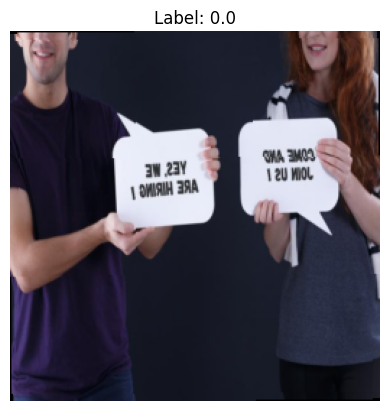

In [8]:
image, label = train_dataset[10001]   
print("Image shape:", image.shape)
print("Label:", label)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label.item()}")
plt.axis("off")

plt.show()

## Creating a Pytorch CNN model

Device configuration

Amd

In [9]:
import torch_directml

device=torch_directml.device(1)
print("Device: ",device)

Device:  privateuseone:1


Nvidia/Muu

In [14]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

Device:  cpu


Hyperparameters

In [10]:
num_epochs = 5
learing_rate= 0.0005

Defining the Pytroch model<br>
Layers consist of conuvlution+relu and pooling for feature learning after which classification

In [11]:
class AiImageClassifier(nn.Module):
    def __init__ (self):
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=3, #3 input channels rgb
                      out_channels=32, # 32 feature maps
                      kernel_size=3, # 3x3 patch of the image
                      padding=1), #padding so outputs the same as input
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2=nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),   # looks for patterns
            nn.BatchNorm2d(64),
            nn.ReLU(),                      # makes the model non linear
            nn.MaxPool2d(2)                 # Shrinks the image, keeping strong signals
        )
        self.conv_block3=nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block4=nn.Sequential(
            nn.Conv2d(128,256,3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.pooling=nn.AdaptiveAvgPool2d((1,1))

        self.fc1=nn.Linear(256,128) # 256 features into 128
        self.dropout=nn.Dropout(0.5) # for overfitting
        self.fc2=nn.Linear(128,1) # single layer for binary classificiation
        # self.sigmoid=nn.Sigmoid() # 0 or 1
        

    
    def forward(self, x):
        x=self.conv_block1(x)   # [batch, 32, 128, 128]
        x=self.conv_block2(x)   # [batch, 64, 64, 64]
        x=self.conv_block3(x)   # [batch, 128, 32, 32]
        x=self.conv_block4(x)
        x=self.pooling(x)
        x=x.view(x.size(0),-1)  # turns 3d feature map into 1D vector
        x=self.fc1(x)
        x=self.dropout(x)           
        x=self.fc2(x)           # combines layers for final prediciton
        return x # returns 0 or 1

Training the model

In [12]:
model=AiImageClassifier().to(device)
criterion=nn.BCEWithLogitsLoss() # Binary Cross Entropy 
optimizer=optim.Adam(model.parameters(),lr=learing_rate) 

n_total_steps=len(train_loader) 
for epoch in range(num_epochs): 
    model.train() 
    running_loss=0 # track loss 
    
    # Looping over all batches in the training set 
    for i, (images,labels) in enumerate(train_loader): 
        images=images.to(device)
        labels=labels.float().unsqueeze(1).to(device) 
        
        #forward pass and computing loss 
        outputs=model(images)
        loss=criterion(outputs,labels)
        
        #backward and optimize 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        #update weights 
        running_loss+=loss.item()
        #print avg loss every 50 steps 
        if (i+1)%50==0: 
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}') 
    print(f'Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {running_loss / n_total_steps:.4f}') 
print('Finished training')

c:\Users\Andreas\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:3244: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)


Epoch [1/5], Step [50/750], Loss: 0.3028
Epoch [1/5], Step [100/750], Loss: 0.2343
Epoch [1/5], Step [150/750], Loss: 0.2380
Epoch [1/5], Step [200/750], Loss: 0.1769
Epoch [1/5], Step [250/750], Loss: 0.2954
Epoch [1/5], Step [300/750], Loss: 0.4072
Epoch [1/5], Step [350/750], Loss: 0.1940
Epoch [1/5], Step [400/750], Loss: 0.3223
Epoch [1/5], Step [450/750], Loss: 0.2158
Epoch [1/5], Step [500/750], Loss: 0.1787
Epoch [1/5], Step [550/750], Loss: 0.2790
Epoch [1/5], Step [600/750], Loss: 0.0951
Epoch [1/5], Step [650/750], Loss: 0.1560
Epoch [1/5], Step [700/750], Loss: 0.1797
Epoch [1/5], Step [750/750], Loss: 0.1723
Epoch [1/5] finished, Average Loss: 0.2586
Epoch [2/5], Step [50/750], Loss: 0.2015
Epoch [2/5], Step [100/750], Loss: 0.1579
Epoch [2/5], Step [150/750], Loss: 0.1253
Epoch [2/5], Step [200/750], Loss: 0.1781
Epoch [2/5], Step [250/750], Loss: 0.2542
Epoch [2/5], Step [300/750], Loss: 0.2123
Epoch [2/5], Step [350/750], Loss: 0.2939
Epoch [2/5], Step [400/750], Loss: 

Calculating accuracy

In [13]:
model.eval()
all_labels=[]
predictions=[]
probabilities=[]

#no gradient computation
with torch.no_grad():
    for images,labels in test_loader:
        images=images.to(device)
        labels=labels.float().unsqueeze(1).to(device)
        
        outputs=model(images)
        probs=torch.sigmoid(outputs)
        preds=(probs > 0.5).int() #Probabilities to binary predicitons
        
        all_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

all_labels=np.array(all_labels).flatten()
predictions=np.array(predictions).flatten()
probabilities=np.array(probabilities).flatten()

acc=accuracy_score(all_labels,predictions)
prec=precision_score(all_labels,predictions)
rec=recall_score(all_labels,predictions)
f1=f1_score(all_labels,predictions)
cm=confusion_matrix(all_labels,predictions)

print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec:.2f}")
print(f"Recall   : {rec:.2f}")
print(f"F1-score : {f1:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy : 54.30%
Precision: 0.87
Recall   : 0.14
F1-score : 0.25
Confusion Matrix:
[[1558   37]
 [1482  247]]
